In [145]:
# joining in R with fuzzy match gave better results, therefore we import that table
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, pearsonr
import statsmodels.api as sm
import numpy as np
from scipy import stats 
# Path to your Excel file
file_path = 'joined_data.xlsx'

# Read the specific sheet from the Excel file
sheet_name = 'All best match'

# Read the data from the Excel file
df = pd.read_excel(file_path, sheet_name=sheet_name)

#we take the values that are included in the analysis
df=df[df['included']==1]
df=df[df['completed']==1]
df=df[df['outliers']==0]


In [146]:
def descriptive_statistics(df, start_col, end_col):
   
    # Select specified columns
    selected_columns = df.iloc[:, start_col:end_col]
    
    # Calculate descriptive statistics
    n_values = selected_columns.count()
    mean_values = selected_columns.mean()
    std_error_values = selected_columns.sem()
    median_values = selected_columns.median()
    std_dev_values = selected_columns.std()
    variance_values = selected_columns.var()
    min_values = selected_columns.min()
    max_values = selected_columns.max()
    
    # Combine all statistics into a DataFrame for better readability
    stats_df = pd.DataFrame({
        'N': round(n_values,2),
        'Mean': round(mean_values,2),
        'Std. Error': round(std_error_values,2),
        'Median': round(median_values,2),
        'Std. Deviation': round(std_dev_values,2),
        'Variance': round(variance_values,2),
        'Minimum': round(min_values,2),
        'Maximum': round(max_values,2)
    })
    
    return stats_df

# Get descriptive statistics for flanker task
stats_df_f = descriptive_statistics(df, 4, 13)

# Output the results
print(stats_df_f)
#stats_df_f.to_excel('stats_df_f.xlsx')

                   N    Mean  Std. Error  Median  Std. Deviation  Variance  \
percenterrors     89    1.44        0.27    0.00            2.54      6.45   
meanRT            89  558.61       12.62  536.88          119.04  14171.11   
percenterrors_c   89    0.79        0.23    0.00            2.13      4.55   
meanrt_c          89  534.94       12.81  510.57          120.81  14596.16   
percenterrors_ic  89    2.10        0.38    0.00            3.57     12.72   
meanrt_ic         89  582.68       13.10  557.63          123.60  15276.84   
outliers          89    0.00        0.00    0.00            0.00      0.00   
CII_ACC           89    0.99        0.00    1.00            0.03      0.00   
CII_RT            89    0.90        0.01    0.91            0.07      0.00   

                  Minimum  Maximum  
percenterrors        0.00    18.33  
meanRT             386.76   927.41  
percenterrors_c      0.00    13.33  
meanrt_c           359.33   959.80  
percenterrors_ic     0.00    23.33

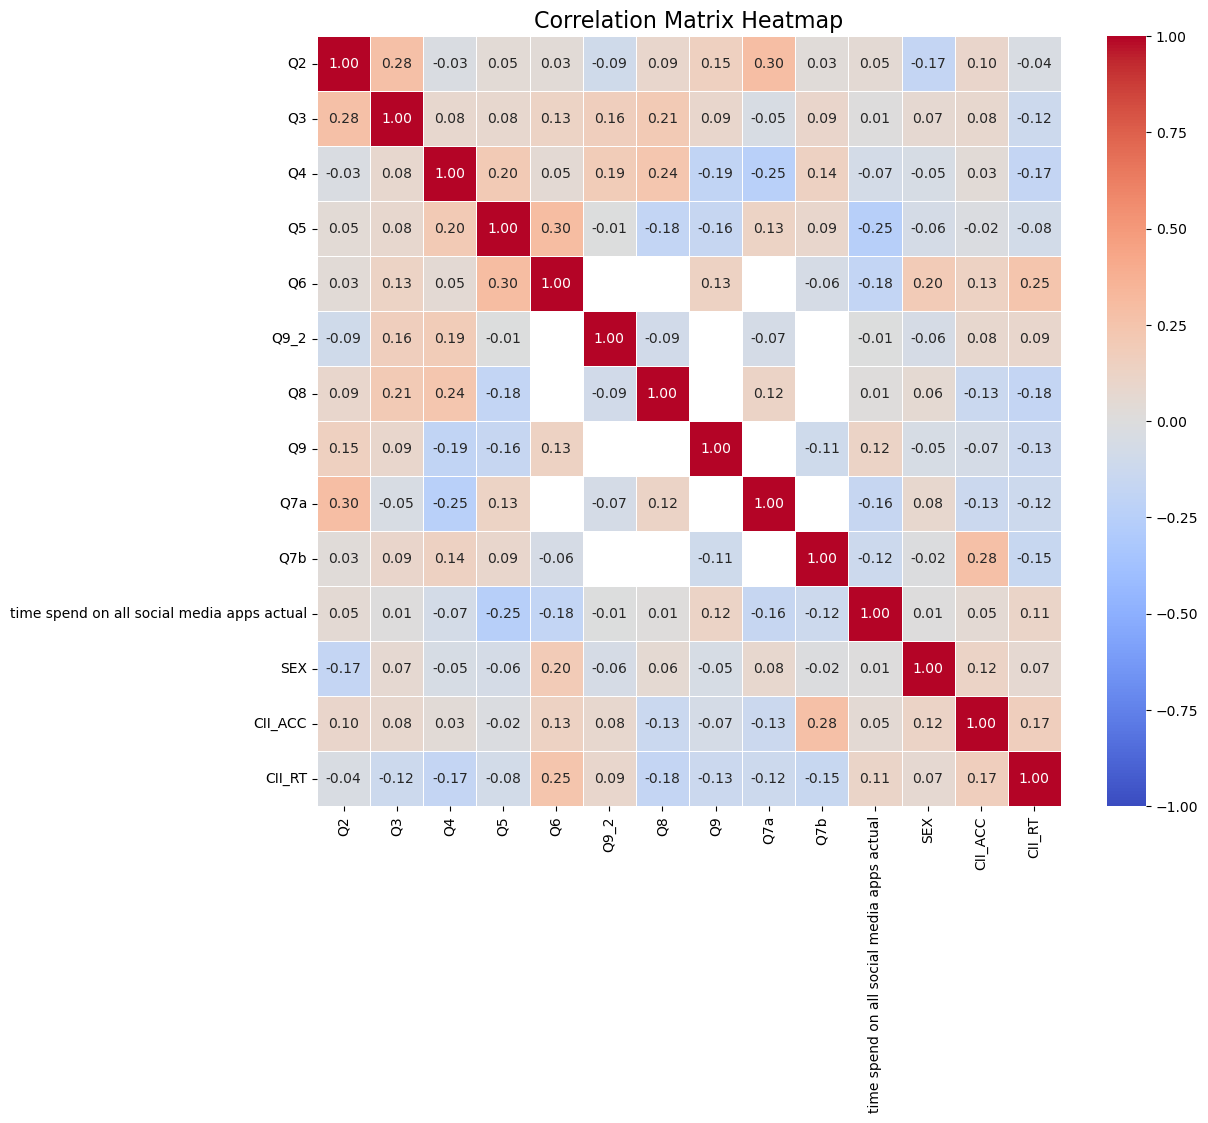

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation = df[['Q2','Q3','Q4','Q5','Q6','Q9_2','Q8','Q9','Q7a','Q7b' ,'time spend on all social media apps actual','SEX','CII_ACC', 'CII_RT']].corr()
correlation

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set plot title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()

In [63]:
#correaltion analysis for instagram and tiktok
from scipy.stats import ttest_ind, pearsonr
actual_cols = ['Instagram actual','TikTok actual']
df['avg_actual'] = df[actual_cols].mean(axis=1, skipna=True)
flanker_cols = df.columns[11:13]
# Correlation analysis
print("\nCorrelation between Social Media Usage for Instagram and TikTok and Flanker Task Performance:")
for col in flanker_cols:
    corr, _ = pearsonr(df['avg_actual'].dropna(), df[col].dropna())
    print(f"Correlation between avg_actual and {col}: {corr}")


# Hypothesis testing
high_usage = df[df['avg_actual'] > df['avg_actual'].median()]
low_usage = df[df['avg_actual'] <= df['avg_actual'].median()]

print("\nT-test for differences in Flanker Task Performance between High and Low Social Media Usage for Instagram and TikTok:")
for col in flanker_cols:
    t_stat, p_val = ttest_ind(high_usage[col].dropna(), low_usage[col].dropna(), equal_var=False)
    print(f"T-test for {col}: t-stat={t_stat}, p-value={p_val}")





Correlation between Social Media Usage and Flanker Task Performance:
Correlation between avg_actual and CII_ACC: 0.1005834264005397
Correlation between avg_actual and CII_RT: -0.005183911290169958

T-test for differences in Flanker Task Performance between High and Low Social Media Usage:
T-test for CII_ACC: t-stat=0.3607786893380329, p-value=0.7193845976188505
T-test for CII_RT: t-stat=-0.04718969920649684, p-value=0.9624691633986834


The correlations between social media usage and Flanker task performance (both accuracy and reaction time) are very weak, indicating a slight relationship, but not strong enough to be meaningful.

The t-tests show no significant differences in Flanker task performance between participants with high and low social media usage. This suggests that social media usage does not have a substantial impact on the accuracy or reaction times in the Flanker task among the participants in the study.

In [147]:
# transforming risk taking outcomes into just one variable for lotteries, to see if we find some siginifcant resutls
# Create a risk-taking variable
def classify_risk_taking(row):
    num_risky = sum(row[col] == 1 for col in lotteries)
    num_safe = sum(row[col] == 0 for col in lotteries)
    if num_risky > num_safe:
        return 1  # Risk-taking
    elif num_safe > num_risky:
        return 2   # Risk-averse
    else:
        return 0   # Neutral

df['risk_taking'] = df.apply(classify_risk_taking, axis=1)
# Risk-taking framing  from scenarios
scenarios_columns = ['Q8', 'Q9', 'Q7a', 'Q7b']
def classify_framing(row):
    num_risky = sum(row[col] == 1 for col in scenarios_columns)
    num_safe = sum(row[col] == 0 for col in scenarios_columns)
    if num_risky == 2:
        return 0  
    elif num_safe == 2:
        return 0   
    else:
        return 1   
    
    
df['framing'] = df.apply(classify_framing, axis=1)
sum(df['framing'])

# Create the new variable
def categorize_usage(minutes):
    if minutes <= 190: #190,150
        return 0
    elif minutes <= 270: #270
        return 1
    else:
        return 2

df['social_media_group'] = df['time spend on all social media apps actual'].apply(categorize_usage)

In [148]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Linear regression example for flanker task score (CII_RT as dependent variable) and all social media
X = df[['time spend on all social media apps actual','SEX','AGE']]
y = df['CII_RT']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CII_RT   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.4306
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.732
Time:                        15:04:33   Log-Likelihood:                 113.17
No. Observations:                  89   AIC:                            -218.3
Df Residuals:                      85   BIC:                            -208.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [149]:
import matplotlib.pyplot as plt
import statsmodels.api as sm


df['sa'] = df['framing'] * df['SEX']
# Convert categorical variable to dummy/indicator variables
df_dummies = pd.get_dummies(df[['social_media_group', 'SEX', 'AGE','risk_taking','sa']], drop_first=True)

# Define predictors and response variable
X = df_dummies
X = sm.add_constant(X)  # Add constant term for the intercept
y = df['CII_RT']

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CII_RT   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.6478
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.664
Time:                        15:05:07   Log-Likelihood:                 114.20
No. Observations:                  89   AIC:                            -216.4
Df Residuals:                      83   BIC:                            -201.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.7814      0

In [150]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
columns_errors = ['percenterrors_c','percenterrors_ic']
columns_reaction_time = ['meanrt_c','meanrt_ic']
# Convert categorical variable to dummy/indicator variables
df['sa'] = df['SEX'] * df['AGE']
df_dummies = pd.get_dummies(df[['percenterrors_ic','meanrt_c','AGE','meanrt_ic','risk_taking']], drop_first=True)

# Define predictors and response variable
X = df_dummies

y = df['social_media_group' ]

# Fit the OLS model
model = OrderedModel(y, X).fit()

# Print the summary
print(model.summary())

                             OrderedModel Results                             
Dep. Variable:     social_media_group   Log-Likelihood:                -92.314
Model:                   OrderedModel   AIC:                             198.6
Method:            Maximum Likelihood   BIC:                             216.0
Date:                Wed, 14 Aug 2024                                         
Time:                        15:05:49                                         
No. Observations:                  89                                         
Df Residuals:                      82                                         
Df Model:                           5                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
percenterrors_ic    -0.0122      0.033     -0.372      0.710      -0.076       0.052
meanrt_c             0.0001      0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:737: RuntimeWarning: Maximum number of iterations has been exceeded.
  retvals = optimize.fmin(f, start_params, args=fargs, xtol=xtol,
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [151]:
# Linear regression example for flanker task score (CII_RT as dependent variable) and instagram and tiktok
X = df[['Instagram actual','TikTok actual','SEX','AGE','risk_taking']]
y = df['CII_RT']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CII_RT   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.046
Method:                 Least Squares   F-statistic:                    0.2336
Date:                Wed, 14 Aug 2024   Prob (F-statistic):              0.947
Time:                        15:05:59   Log-Likelihood:                 113.12
No. Observations:                  89   AIC:                            -214.2
Df Residuals:                      83   BIC:                            -199.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.8109      0.143  

In [153]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

# Prepare data for ordinal logistic regression
df['social_media_group'] = df['social_media_group'].astype('category').cat.codes
X = df[['social_media_group', 'SEX','CII_RT']]
y = df['risk_taking']

# Fit the ordinal logistic regression model
model = OrderedModel(y, X, distr='logit')
result = model.fit(method='bfgs')

# Display the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.661655
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:            risk_taking   Log-Likelihood:                -58.887
Model:                   OrderedModel   AIC:                             125.8
Method:            Maximum Likelihood   BIC:                             135.7
Date:                Wed, 14 Aug 2024                                         
Time:                        15:06:28                                         
No. Observations:                  89                                         
Df Residuals:                      85                                         
Df Model:                           3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

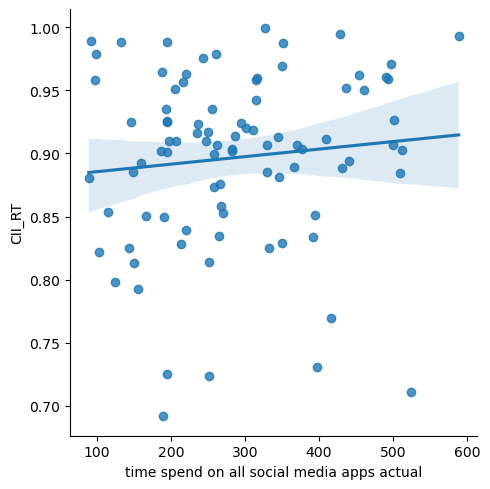

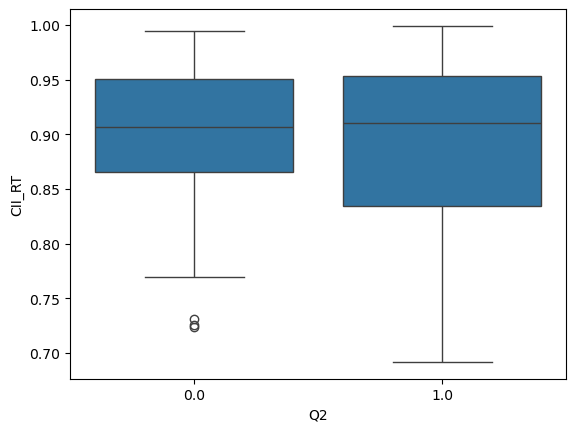

In [154]:
# Visualization
sns.lmplot(x='time spend on all social media apps actual', y='CII_RT', data=df)
plt.show()

sns.boxplot(x='Q2', y='CII_RT', data=df)
plt.show()

In [155]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Random Forest Example for binary outcome
X = df[['CII_ACC','CII_RT','SEX','AGE','social_media_group']]
y = df['risk_taking']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

           1       0.27      0.23      0.25        13
           2       0.38      0.43      0.40        14

    accuracy                           0.33        27
   macro avg       0.32      0.33      0.33        27
weighted avg       0.33      0.33      0.33        27



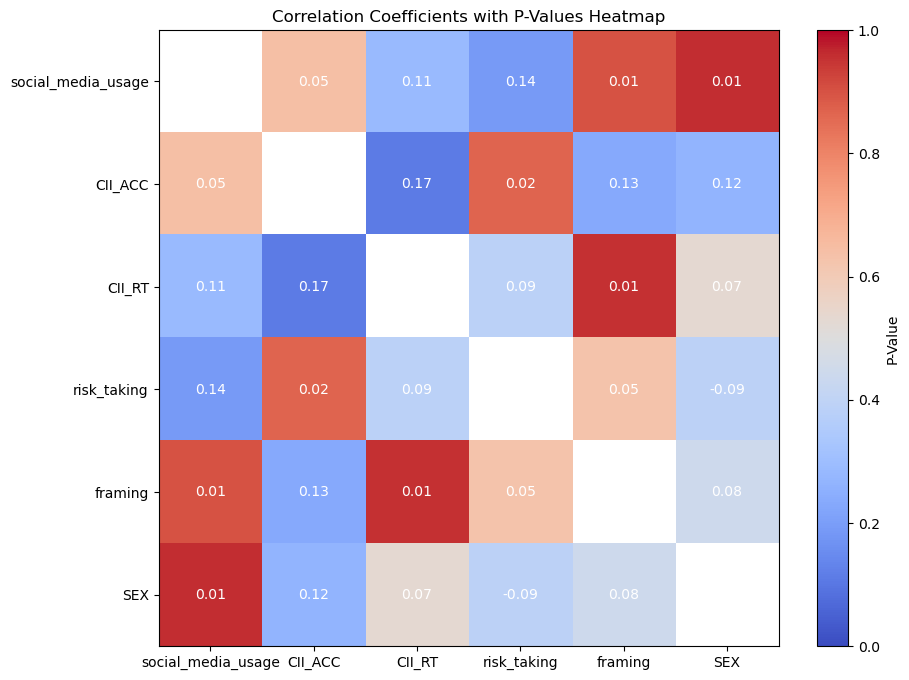

In [39]:
#survey.rename(columns={'time spend on all social media apps actual': 'social_media_usage','Instagram actual':'Instagram','TikTok actual':'TikTok'}, inplace=True)
df.rename(columns={'time spend on all social media apps actual': 'social_media_usage','Instagram actual':'Instagram','TikTok actual':'TikTok'}, inplace=True)
columns = ['social_media_usage','CII_ACC','CII_RT','risk_taking','framing','SEX']
n = len(columns)

# Create matrices to store correlation coefficients and p-values
correlation_matrix = np.zeros((n, n))
p_value_matrix = np.zeros((n, n))

# Calculate correlation coefficients and p-values
for i in range(n):
    for j in range(n):
        if i == j:
            correlation_matrix[i, j] = np.nan
            p_value_matrix[i, j] = np.nan
        else:
            corr, p_value = pearsonr(df[columns[i]], df[columns[j]])
            correlation_matrix[i, j] = corr
            p_value_matrix[i, j] = p_value

# Create a combined DataFrame for plotting
combined_df = pd.DataFrame({
    'Correlation': correlation_matrix.flatten(),
    'P-Value': p_value_matrix.flatten(),
    'Row': np.repeat(range(n), n),
    'Col': np.tile(range(n), n)
})

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create a color map for p-values
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=0, vmax=1)

# Create the heatmap
heatmap = ax.imshow(p_value_matrix, cmap=cmap, norm=norm, aspect='auto')

# Annotate with correlation coefficients and significance stars
for i in range(n):
    for j in range(n):
        if not np.isnan(correlation_matrix[i, j]):
            value = correlation_matrix[i, j]
            p_value = p_value_matrix[i, j]
            annotation = f'{value:.2f}'
            if p_value < 0.05:
                annotation += ' **'
            elif p_value < 0.1:
                annotation += ' *'
            ax.text(j, i, annotation,
                    ha='center', va='center', color='white')

# Add color bar and labels
cbar = plt.colorbar(heatmap, ax=ax, orientation='vertical')
cbar.set_label('P-Value')

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(columns)
ax.set_yticklabels(columns)
ax.set_title('Correlation Coefficients with P-Values Heatmap')

plt.show()

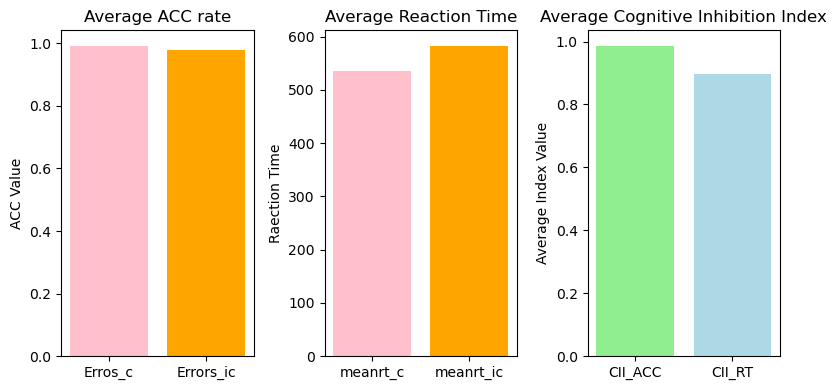

In [156]:
columns_errors = ['percenterrors_c','percenterrors_ic']
columns_reaction_time = ['meanrt_c','meanrt_ic']

# Calculate the average pecent errors and raction times
average_ACC= [1-df[f"{column}"].mean()/100 for column in columns_errors]
average_rt = [df[f"{column}"].mean() for column in columns_reaction_time]# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

# Plot the average percent errors
axes[0].bar(['Erros_c','Errors_ic'], average_ACC, color=['pink', 'orange'])
axes[0].set_ylabel('ACC Value')
axes[0].set_title('Average ACC rate')

# Plot the average reaction times
axes[1].bar(columns_reaction_time, average_rt, color=['pink', 'orange'])
axes[1].set_ylabel('Raection Time')
axes[1].set_title('Average Reaction Time')

# Calculate the average CII_ACC and CII_RT
average_cii_acc = df['CII_ACC'].mean()
average_cii_rt = df['CII_RT'].mean()

# Plot the average CII_ACC and CII_RT
labels = ['CII_ACC', 'CII_RT']
averages = [average_cii_acc, average_cii_rt]

axes[2].bar(labels, averages, color=['lightgreen', 'lightblue'])
axes[2].set_ylabel('Average Index Value')
axes[2].set_title('Average Cognitive Inhibition Index')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()
